In [ ]:
import torch
device = "cuda"
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import pandas as pd

In [11]:
academic_words =  [
                      "however", "therefore", "consequently",
                      "analysis", "methodology", "significant",
                      "furthermore", "evidence", "demonstrates"
                  ]
casual_words = [
            "lol", "yeah", "gonna", "wanna", "basically",
            "like", "kinda", "sorta"
            ]

banned_words = ["shit"]

In [12]:
class StyleController:
    """
    Modular linguistic/style controller for academic auto-completion.
    Works with any HuggingFace-style tokenizer & model.
    """

    def __init__(
        self,
        tokenizer,
        academic_words=academic_words,
        casual_words=casual_words,
        banned_words=banned_words,
        boost=2.0,
        penalty=4.0,
        use_prefix=True,
    ):
        self.tokenizer = tokenizer
        self.boost = boost
        self.penalty = penalty
        self.use_prefix = use_prefix

        # Default word lists
        self.academic_words = academic_words

        self.casual_words = casual_words

        self.banned_words = banned_words

        # Token IDs
        self.academic_ids = self._words_to_token_ids(self.academic_words)
        self.casual_ids = self._words_to_token_ids(self.casual_words)
        self.banned_ids = self._words_to_token_ids(self.banned_words)

        # Prefix for academic tone
        self.prefix = (
            "Write the continuation below in a formal academic style, "
            "using precise vocabulary and objective reasoning.\n"
        )

    def _words_to_token_ids(self, words):
        ids = []
        for w in words:
            tokens = self.tokenizer.tokenize(w)
            if len(tokens) == 1:
                tid = self.tokenizer.convert_tokens_to_ids(tokens[0])
                ids.append(tid)
        return ids

    def apply_prefix(self, text: str):
        if self.use_prefix:
            return self.prefix + text
        return text

    def apply_logits_control(self, logits):
        """Apply style-based logits modification with device-safe indexing."""
        device = logits.device
        acad = torch.tensor(self.academic_ids, device=device)
        cas = torch.tensor(self.casual_ids, device=device)
        ban = torch.tensor(self.banned_ids, device=device)

        # Academic boost
        logits[:, acad] += self.boost

        # Penalize informal language
        logits[:, cas] -= self.penalty

        # Hard ban
        logits[:, ban] = -1e4

        return logits


In [17]:
# Path where you saved LoRA model
model_path = "./lora_academic_model"

# 1┒┓ Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# GPT2 requires pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2┒┓ Load base model (must match the one you fine-tuned)
base_model_name = "EleutherAI/gpt-neo-125M"  # Corrected from "gpt2"
model = AutoModelForCausalLM.from_pretrained(base_model_name, torch_dtype=torch.float16)

# 3┒┓ Load LoRA adapters
model = PeftModel.from_pretrained(model, model_path)

# 4┒┓ Put model in evaluation mode
model.eval()
model.to(device) # Ensure 'device' is accessible, it was defined in cell e564ea4d

controller = StyleController(tokenizer)

context = "Deep reinforcement learning has been widely adopted in robotic navigation."

# Apply prefix (optional)
input_text = controller.apply_prefix(context)

# Ensure input ids are on the same device as the model
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

generated = []

# Precompute stop token ids for sentence termination
stop_tokens = ['.', '!', '?']
stop_ids = set()
for s in stop_tokens:
    ids = tokenizer.encode(s, add_special_tokens=False)
    stop_ids.update(ids)
# Also include EOS if available
if tokenizer.eos_token_id is not None:
    stop_ids.add(tokenizer.eos_token_id)

while True:
    outputs = model(input_ids)
    logits = outputs.logits[:, -1, :]

    logits = controller.apply_logits_control(logits)

    next_token = torch.argmax(logits, dim=-1)
    input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=-1)
    item = next_token.item()
    generated.append(item)

    # Stop when next token is a sentence terminator or EOS
    if item in stop_ids:
        break

result = tokenizer.decode(generated, skip_special_tokens=True)
print(context, "\n")
print(result)

Deep reinforcement learning has been widely adopted in robotic navigation. 

 It is a method of learning from a sequence of actions, which is a sequence of actions that are learned from a sequence of actions.


## Vocabulary & Token Distribution

Tokenize your corpus and compute frequencies to decide on tokenizer retraining or adding special tokens.

In [19]:
# Loading the data
from dataset_utils import build_academic_dataset
df = build_academic_dataset(tokenizer=None, limit_each=300)
contexts = df['context']
print(df.head())

Loading datasets...
Loading ASAP Essays
Total raw documents loaded: 300
Generating (context, continuation) pairs...
Generated 299 training pairs.
                                             context  \
0  A long time ago when I was in third grade I ha...   
1  Softball has to be one of the single most grea...   
2  Some people like making people laugh, I love i...   
3  "LAUGHTER" @CAPS1 I hang out with my friends, ...   
4  Well ima tell a story about the time i got @CA...   

                                        continuation  
0  The next day @PERSON2 and I were eating lunch ...  
1  Many of these girls were like sisters to me th...  
2  For example one time I hit myself in the head ...  
3  @CAPS1 I say trash can I really mean trash can...  
4  Then she said stupid @CAPS2 on the bus and com...  


In [20]:
import pandas as pd

# Ensure df is available; if not, you might need to re-run previous cells that load/create df
if 'df' in locals() and isinstance(df, pd.DataFrame):
    # Concatenate context and continuation into a single text column for the corpus
    corpus_data = (df['context'] + " " + df['continuation']).tolist()

    # Write the combined texts to corpus.txt
    with open('corpus.txt', 'w', encoding='utf-8') as f:
        for line in corpus_data:
            f.write(line + '\n')
    print("Corpus.txt created from DataFrame 'df'.")
else:
    print("DataFrame 'df' not found. Please ensure it is loaded or created before running this cell.")

Corpus.txt created from DataFrame 'df'.


### Create tokenizer graph and tokenizer count json

Loading tokenizer...
Loading corpus...
Tokenizing corpus...


100%|██████████| 299/299 [00:00<00:00, 3012.10it/s]


Saved token frequencies → token_freq.json

⏶️ Top frequent tokens:
.	2676
 @	1955
,	1807
 the	1570
 and	1460
 to	1448
 I	1395
S	1264
CAP	1262
 a	1167
1	916
 of	897
 was	823
 that	740
 my	738
 in	657
 we	579
 is	565
 it	520
 with	447
 you	445
 me	404
2	394
 for	339
 have	321
 on	307
P	300
ERSON	300
't	299

	299
 had	286
 laugh	286
 laughter	281
 at	276
 be	274
 i	272
 were	268
 can	268
 all	261
3	251
 when	236
 one	235
ATION	232
 people	225
 so	222
 would	219
 out	218
's	213
 or	213
 time	204
 are	203
 about	203
 her	201
 but	200
 just	197
 up	196
 friends	188
aughter	180
 like	178
 day	176
 as	175
 they	173
 there	164
 he	161
 because	160
 not	158
 We	155
 laughing	154
 get	149
 us	149
 other	149
 make	144
 she	141
 life	141
D	141
 It	140
ATE	140
 always	137
 our	134
4	131
 friend	127
 could	126
 best	126
 go	126
 from	123
OR	123
GAN	123
IZ	123
 this	122
 The	120
 good	119
 really	116
 know	113
 them	113
 do	112
 what	112
 your	111
 going	111
 got	110
LOC	109
 something	106
 even	106



Saved Zipf plot → token_zipf_curve.png

 Subword Fragmentation:

Phrase: reinforcement learning
Tokens: ['re', 'in', 'forcement', 'Ġlearning']
Token count: 4

Phrase: policy gradient
Tokens: ['policy', 'Ġgradient']
Token count: 2

Phrase: actor-critic
Tokens: ['actor', '-', 'crit', 'ic']
Token count: 4

Phrase: entropy regularization
Tokens: ['ent', 'ropy', 'Ġregular', 'ization']
Token count: 4

Phrase: state transition
Tokens: ['state', 'Ġtransition']
Token count: 2

Phrase: Markov decision process
Tokens: ['Mark', 'ov', 'Ġdecision', 'Ġprocess']
Token count: 4

Phrase: optimization
Tokens: ['optim', 'ization']
Token count: 2

Phrase: generalization
Tokens: ['general', 'ization']
Token count: 2

Phrase: empirical evaluation
Tokens: ['em', 'pir', 'ical', 'Ġevaluation']
Token count: 4


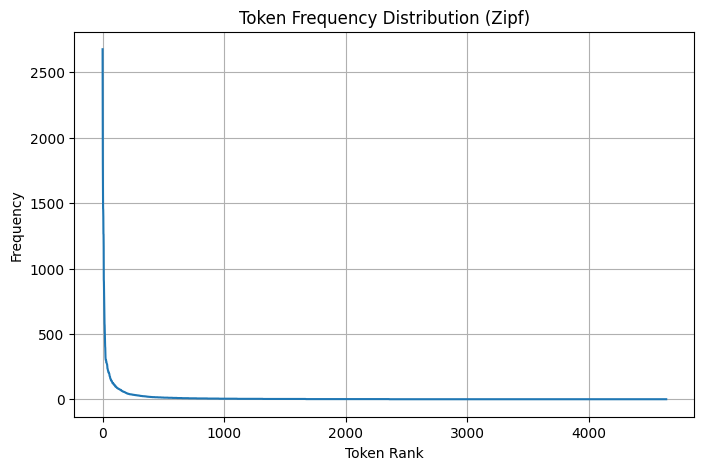

In [21]:
import json
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer

# -------------------------------
# Config
# -------------------------------
MODEL_NAME = "gpt2"        # or your existing tokenizer
CORPUS_PATH = "corpus.txt" # your academic/student corpus
TOP_N = 200                # how many tokens to print


# -------------------------------
# Load tokenizer & corpus
# -------------------------------
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Loading corpus...")
with open(CORPUS_PATH, "r", encoding="utf-8") as f:
    corpus_lines = f.readlines()


# -------------------------------
# Count token frequencies
# -------------------------------
freq = collections.Counter()

print("Tokenizing corpus...")
for line in tqdm(corpus_lines):
    tokens = tokenizer.encode(line, add_special_tokens=False)
    freq.update(tokens)

# Convert token IDs → strings
token_freq = {tokenizer.decode([tid]): count for tid, count in freq.items()}


# -------------------------------
# Save frequency file
# -------------------------------
with open("token_freq.json", "w") as f:
    json.dump(token_freq, f, indent=2)

print("\nSaved token frequencies → token_freq.json")


# -------------------------------
# Print top-N & rare tokens
# -------------------------------
print("\n⏶️ Top frequent tokens:")
for w, c in freq.most_common(TOP_N):
    print(f"{tokenizer.decode([w])}\t{c}")

print("\n❗️ Rare tokens:")
for w, c in freq.most_common()[-TOP_N:]:
    print(f"{tokenizer.decode([w])}\t{c}")


# -------------------------------
# Zipf Distribution Plot
# -------------------------------
sorted_counts = sorted(freq.values(), reverse=True)
plt.figure(figsize=(8,5))
plt.plot(sorted_counts)
plt.title("Token Frequency Distribution (Zipf)")
plt.xlabel("Token Rank")
plt.ylabel("Frequency")
plt.grid()
plt.savefig("token_zipf_curve.png")
print("\nSaved Zipf plot → token_zipf_curve.png")


# -------------------------------
# Subword Fragmentation Analysis
# -------------------------------
INTEREST_WORDS = [
    "reinforcement learning", "policy gradient", "actor-critic",
    "entropy regularization", "state transition", "Markov decision process",
    "optimization", "generalization", "empirical evaluation",
]

print("\n Subword Fragmentation:")
for phrase in INTEREST_WORDS:
    ids = tokenizer.encode(phrase, add_special_tokens=False)
    toks = tokenizer.convert_ids_to_tokens(ids)
    print(f"\nPhrase: {phrase}")
    print("Tokens:", toks)
    print("Token count:", len(toks))